In [ ]:
import zipfile
import os

# Path to the uploaded ZIP file
zip_path = '/content/archive (4) _ 3 categories wala.zip'  # <-- Replace with your actual filename

# Directory to extract to
extract_to = '/content/extracted'
os.makedirs(extract_to, exist_ok=True)

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Extracted to: {extract_to}")


Extracted to: /content/extracted


In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold

In [ ]:
# ===========================
# ⚙️ Setup: Data Directories
# ===========================
dataset_path = "./extracted/dataset"  # Replace if needed
categories = ["with_mask", "without_mask", "incorrect_mask"]
label_map = {cat: idx for idx, cat in enumerate(categories)}

train_images = []
train_labels = []

img_size = (128, 128)

In [ ]:
# ===========================
# 📥 Load and Label Images
# ===========================
for label_name, label_index in label_map.items():
    dir_path = os.path.join(dataset_path, label_name)
    for fname in os.listdir(dir_path):
        if fname.lower().endswith(('.jpg', '.png', '.jpeg')):
            img = Image.open(os.path.join(dir_path, fname)).convert("RGB")
            img = img.resize(img_size)
            img_array = np.array(img)
            if img_array.shape == (128, 128, 3):
                train_images.append(img_array)
                train_labels.append(label_index)

In [ ]:
for label_name in categories:
    print(label_name, len(os.listdir(os.path.join(dataset_path, label_name))))


with_mask 690
without_mask 686
incorrect_mask 703


In [ ]:
# ===========================
# ✅ Convert & One-Hot Encode
# ===========================
train_images = np.array(train_images, dtype='float32') / 255.0
train_labels = to_categorical(np.array(train_labels), num_classes=3)

In [ ]:
# ===========================
# 📊 Split Dataset
# ===========================
X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42, stratify=train_labels
)

In [ ]:
# ===========================
# 🔁 Data Augmentation
# ===========================
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)


In [ ]:
# ===========================
# 🧠 Define MobileNetV2 Model
# ===========================
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,340,163 (8.93 MB)

 Trainable params: 2,306,051 (8.80 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
# ===========================
# 🚀 Train the Model
# ===========================
history = model.fit(
    train_generator,
    epochs=16,
    validation_data=val_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 86s 698ms/step - accuracy: 0.7007 - loss: 0.6946 - val_accuracy: 0.3317 - val_loss: 2.0519
Epoch 2/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 205ms/step - accuracy: 0.9701 - loss: 0.0988 - val_accuracy: 0.3317 - val_loss: 2.2567
Epoch 3/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 205ms/step - accuracy: 0.9919 - loss: 0.0481 - val_accuracy: 0.3317 - val_loss: 2.4039
Epoch 4/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 194ms/step - accuracy: 0.9938 - loss: 0.0214 - val_accuracy: 0.3317 - val_loss: 2.0099
Epoch 5/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 190ms/step - accuracy: 0.9952 - loss: 0.0171 - val_accuracy: 0.3317 - val_loss: 1.8385
Epoch 6/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 204ms/step - accuracy: 0.9976 - loss: 0.0113 - val_accuracy: 0.3317 - val_loss: 1.5612
Epoch 7/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 205ms/step - accuracy: 0.9966 - loss: 0.0134 - val_accuracy: 0.3317 - val_loss: 1.4255
Epoch 8/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 206ms/step - accuracy: 0.9941 - loss: 0.0155 - val_accu

In [ ]:
# ===========================
# 💾 Save the Model
# ===========================
model.save("mobilenet_mask_multiclass.h5")
print("✅ Model saved as mobilenet_mask_multiclass.h5")


✅ Model saved as mobilenet_mask_multiclass.h5


🟢 Final Training Accuracy: 0.9988
🔵 Final Validation Accuracy: 0.3317
🟢 Final Training Loss: 0.0036
🔵 Final Validation Loss: 3.4062


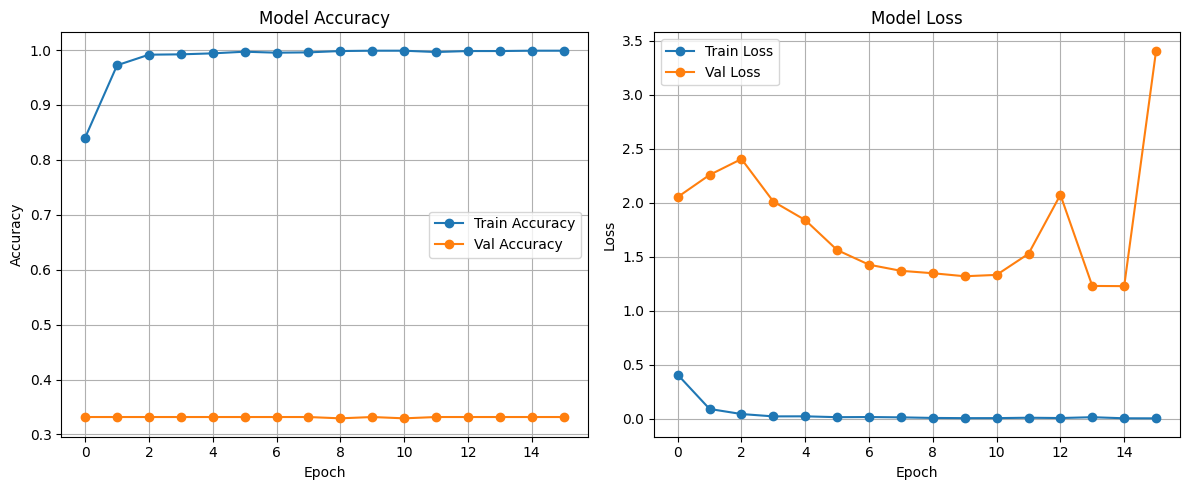

In [ ]:
# ===========================
# 📈 Plot Accuracy & Loss
# ===========================
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

print(f"🟢 Final Training Accuracy: {train_acc:.4f}")
print(f"🔵 Final Validation Accuracy: {val_acc:.4f}")
print(f"🟢 Final Training Loss: {train_loss:.4f}")
print(f"🔵 Final Validation Loss: {val_loss:.4f}")

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.models import load_model

# Define class labels (same order as used in training)
class_labels = ["with_mask", "without_mask", "incorrect_mask"]

def predict_image(image_path, model_path="mobilenet_mask_multiclass.h5"):
    # Load the trained model
    model = load_model(model_path)

    # Load and preprocess the image
    img = Image.open(image_path).convert("RGB")
    img = img.resize((128, 128))
    img_array = np.array(img).astype("float32") / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict
    prediction = model.predict(img_array)[0]
    predicted_class = class_labels[np.argmax(prediction)]
    confidence = np.max(prediction)

    print(f"\n📸 Prediction: {predicted_class}")
    print(f"🔢 Confidence: {confidence:.4f}")
    return predicted_class, confidence


In [ ]:
image_path = input("Enter path to image: ")
predict_image(image_path)



Enter path to image: /content/download.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step

📸 Prediction: without_mask
🔢 Confidence: 0.9953


('without_mask', np.float32(0.99534047))


📂 Fold 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 65s 454ms/step - accuracy: 0.7074 - loss: 0.6426 - val_accuracy: 0.9519 - val_loss: 0.1436
Epoch 2/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.9732 - loss: 0.0876 - val_accuracy: 0.9784 - val_loss: 0.0594
Epoch 3/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 0.9920 - loss: 0.0359 - val_accuracy: 0.9784 - val_loss: 0.0463
Epoch 4/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 0.9954 - loss: 0.0172 - val_accuracy: 0.9880 - val_loss: 0.0367
Epoch 5/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 0.9960 - loss: 0.0186 - val_accuracy: 0.9904 - val_loss: 0.0249
Epoch 6/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 0.9950 - loss: 0.0155 - val_accuracy: 0.9976 - val_loss: 0.0110
Epoch 7/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.9975 - loss: 0.0127 - val_accuracy: 0.9976 - val_loss: 0.0086
Epoch 8/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 0.9983 - loss: 0.0124 - val_accuracy: 

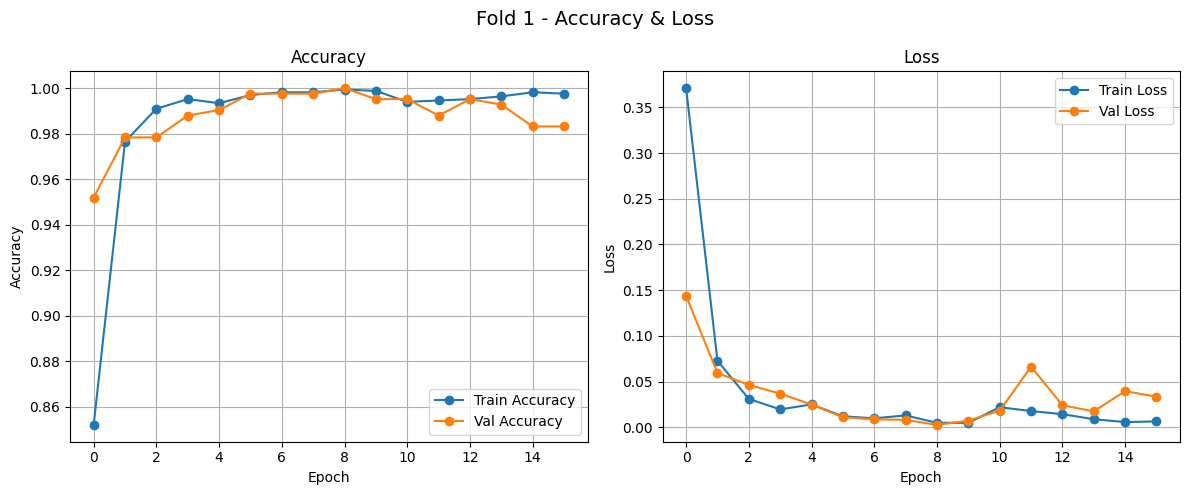


📂 Fold 2/5
Epoch 1/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 62s 469ms/step - accuracy: 0.7285 - loss: 0.6693 - val_accuracy: 0.9327 - val_loss: 0.2190
Epoch 2/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.9772 - loss: 0.0766 - val_accuracy: 0.9615 - val_loss: 0.1194
Epoch 3/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.9869 - loss: 0.0335 - val_accuracy: 0.9688 - val_loss: 0.1227
Epoch 4/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 0.9961 - loss: 0.0166 - val_accuracy: 0.9760 - val_loss: 0.1119
Epoch 5/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.9912 - loss: 0.0202 - val_accuracy: 0.9688 - val_loss: 0.1284
Epoch 6/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.9977 - loss: 0.0070 - val_accuracy: 0.9736 - val_loss: 0.0833
Epoch 7/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.9958 - loss: 0.0106 - val_accuracy: 0.9832 - val_loss: 0.0502
Epoch 8/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.9973 - loss: 0.0088 - va

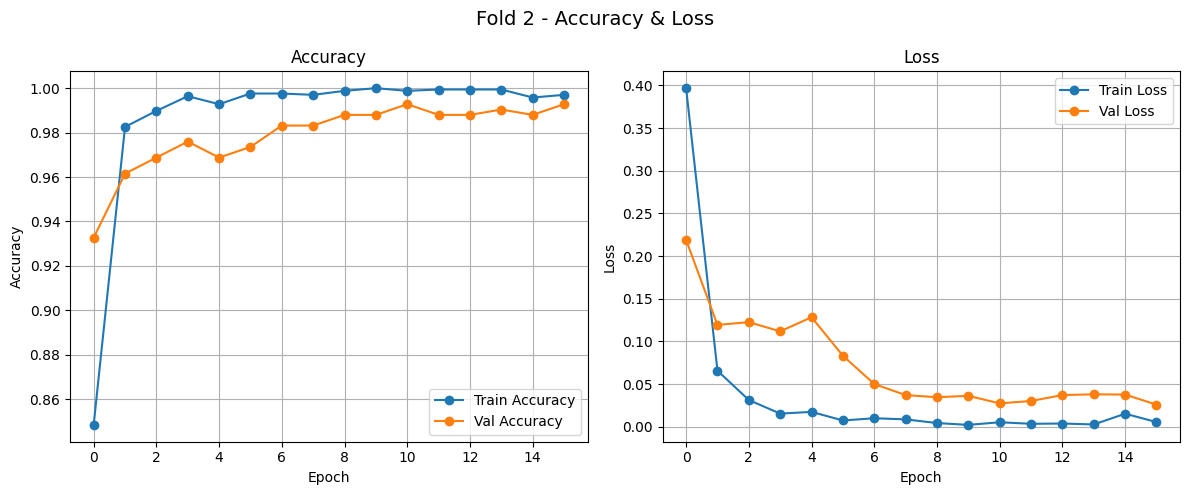


📂 Fold 3/5
Epoch 1/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 62s 472ms/step - accuracy: 0.6281 - loss: 0.8696 - val_accuracy: 0.8966 - val_loss: 0.2968
Epoch 2/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.9778 - loss: 0.0856 - val_accuracy: 0.9591 - val_loss: 0.1310
Epoch 3/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.9868 - loss: 0.0451 - val_accuracy: 0.9712 - val_loss: 0.0916
Epoch 4/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.9969 - loss: 0.0234 - val_accuracy: 0.9832 - val_loss: 0.0539
Epoch 5/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 0.9915 - loss: 0.0271 - val_accuracy: 0.9904 - val_loss: 0.0305
Epoch 6/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.9956 - loss: 0.0165 - val_accuracy: 0.9952 - val_loss: 0.0312
Epoch 7/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 0.9958 - loss: 0.0128 - val_accuracy: 0.9952 - val_loss: 0.0311
Epoch 8/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 0.9970 - loss: 0.0086 - va

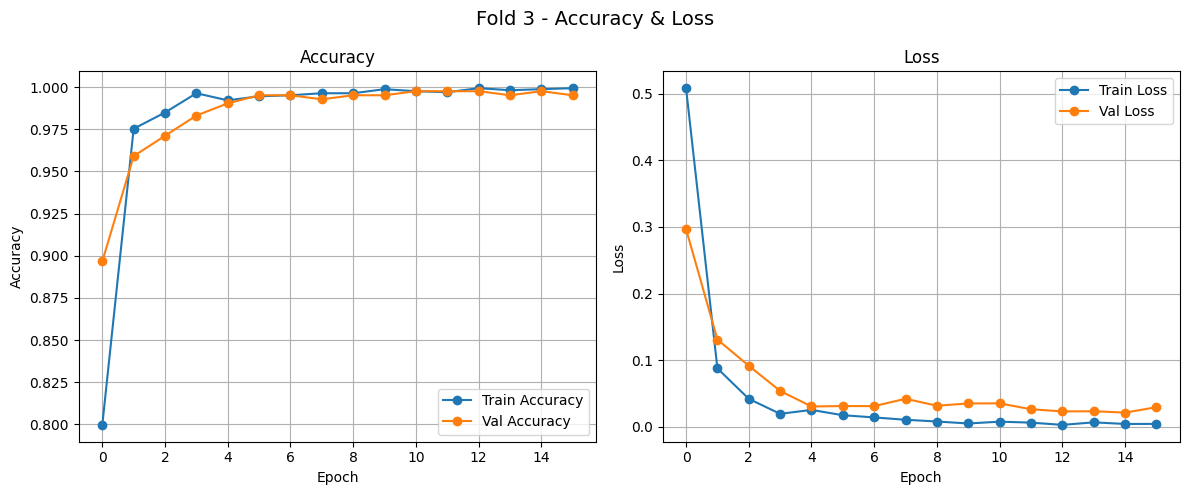


📂 Fold 4/5
Epoch 1/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 64s 476ms/step - accuracy: 0.6957 - loss: 0.6784 - val_accuracy: 0.9014 - val_loss: 0.2540
Epoch 2/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 0.9611 - loss: 0.0957 - val_accuracy: 0.9663 - val_loss: 0.0883
Epoch 3/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 0.9866 - loss: 0.0394 - val_accuracy: 0.9663 - val_loss: 0.1056
Epoch 4/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 0.9956 - loss: 0.0283 - val_accuracy: 0.9688 - val_loss: 0.0896
Epoch 5/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 0.9966 - loss: 0.0154 - val_accuracy: 0.9760 - val_loss: 0.0661
Epoch 6/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 0.9921 - loss: 0.0232 - val_accuracy: 0.9880 - val_loss: 0.0324
Epoch 7/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.9958 - loss: 0.0129 - val_accuracy: 0.9976 - val_loss: 0.0174
Epoch 8/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.9967 - loss: 0.0133 - v

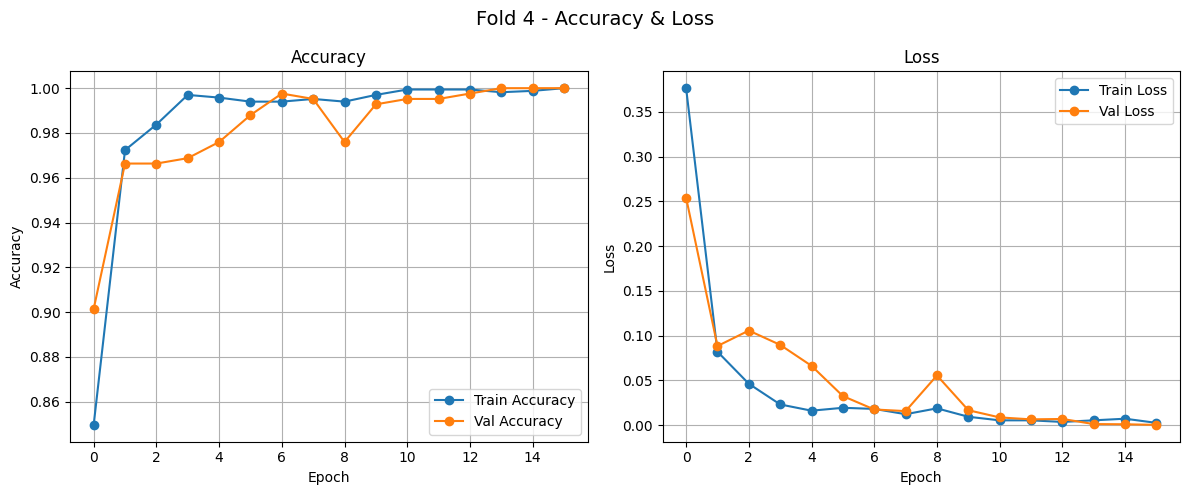


📂 Fold 5/5
Epoch 1/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 52s 238ms/step - accuracy: 0.7238 - loss: 0.7020 - val_accuracy: 0.9639 - val_loss: 0.1098
Epoch 2/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 0.9761 - loss: 0.0780 - val_accuracy: 0.9855 - val_loss: 0.0530
Epoch 3/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.9818 - loss: 0.0450 - val_accuracy: 0.9952 - val_loss: 0.0235
Epoch 4/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.9923 - loss: 0.0193 - val_accuracy: 0.9928 - val_loss: 0.0219
Epoch 5/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 0.9939 - loss: 0.0234 - val_accuracy: 0.9928 - val_loss: 0.0374
Epoch 6/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.9976 - loss: 0.0121 - val_accuracy: 0.9928 - val_loss: 0.0268
Epoch 7/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 0.9972 - loss: 0.0132 - val_accuracy: 0.9928 - val_loss: 0.0201
Epoch 8/16
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.9964 - loss: 0.0088 - va

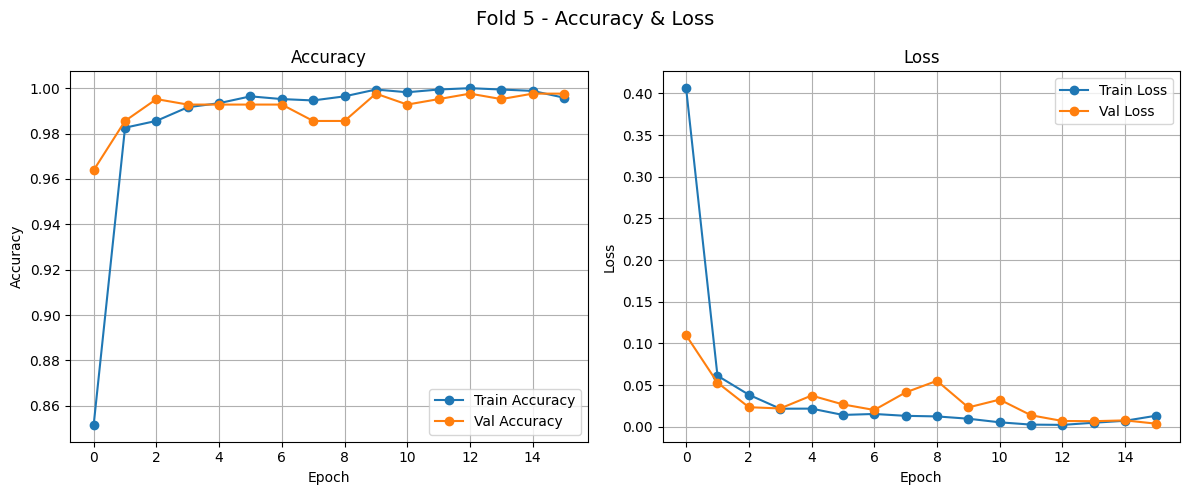


🔚 K-Fold Cross Validation Results:
Fold 1 — Accuracy: 0.9832, Loss: 0.0334
Fold 2 — Accuracy: 0.9928, Loss: 0.0260
Fold 3 — Accuracy: 0.9952, Loss: 0.0295
Fold 4 — Accuracy: 1.0000, Loss: 0.0002
Fold 5 — Accuracy: 0.9976, Loss: 0.0036

📈 Average Accuracy: 0.9937
📉 Average Loss: 0.0186


In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# ===========================
# ⚙️ Load and Preprocess Data
# ===========================
dataset_path = "./extracted/dataset"
categories = ["with_mask", "without_mask", "incorrect_mask"]
label_map = {cat: idx for idx, cat in enumerate(categories)}

img_size = (128, 128)
images = []
labels = []

for label_name, label_index in label_map.items():
    dir_path = os.path.join(dataset_path, label_name)
    for fname in os.listdir(dir_path):
        if fname.lower().endswith(('.jpg', '.png', '.jpeg')):
            img = Image.open(os.path.join(dir_path, fname)).convert("RGB")
            img = img.resize(img_size)
            img_array = np.array(img)
            if img_array.shape == (128, 128, 3):
                images.append(img_array)
                labels.append(label_index)

X = np.array(images, dtype='float32') / 255.0
y = np.array(labels)
y_cat = to_categorical(y, num_classes=3)

# ===========================
# 🔁 K-Fold Cross Validation
# ===========================
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

fold = 1
acc_per_fold = []
loss_per_fold = []

for train_index, val_index in skf.split(X, y):
    print(f"\n📂 Fold {fold}/{k}")

    # Split data
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y_cat[train_index], y_cat[val_index]

    # Data augmentation
    train_datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    val_datagen = ImageDataGenerator()

    train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
    val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

    # Create new model
    base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(128, 128, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(3, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Train
    history = model.fit(
        train_generator,
        epochs=16,
        validation_data=val_generator,
        verbose=1
    )

    # Evaluate
    scores = model.evaluate(val_generator, verbose=0)
    acc_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])

    print(f"✅ Fold {fold} - Loss: {scores[0]:.4f} - Accuracy: {scores[1]:.4f}")

    # ===========================
    # 📊 Plot for this fold
    # ===========================
    plt.figure(figsize=(12, 5))
    plt.suptitle(f'Fold {fold} - Accuracy & Loss', fontsize=14)

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    fold += 1

# ===========================
# 🧮 Final Summary
# ===========================
print("\n🔚 K-Fold Cross Validation Results:")
for i in range(k):
    print(f"Fold {i+1} — Accuracy: {acc_per_fold[i]:.4f}, Loss: {loss_per_fold[i]:.4f}")

print(f"\n📈 Average Accuracy: {np.mean(acc_per_fold):.4f}")
print(f"📉 Average Loss: {np.mean(loss_per_fold):.4f}")


# Converting to tflite

In [ ]:
import tensorflow as tf

# Load your trained Keras model
model = tf.keras.models.load_model("/content/mobilenet_mask_multiclass.h5")

# Create converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# OPTIONAL: Enable optimization for size and speed
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# OPTIONAL: If you want INT8 quantization (smallest & fastest), you also need to set a representative dataset.
# For simplicity, here we keep FP16/FP32. Let me know if you want full INT8 code.

# Convert model
tflite_model = converter.convert()

# Save to file
with open("mobilenet_mask_detector.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ TFLite model saved as mobilenet_mask_detector.tflite")


Saved artifact at '/tmp/tmpp8oqk53l'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  132047625073488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132047625075216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132047625075600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132047625075408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132047625074064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132047625074640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132046995964368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132046995964944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132047625074832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132047625073872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1320469959659

# Adding INT8 Quantization

In [ ]:
# ================================
# 🚀 1) Load Keras Model
# ================================
import tensorflow as tf
import numpy as np
from PIL import Image
import time

model = tf.keras.models.load_model("/content/mobilenet_mask_multiclass.h5")

# ================================
# 🚀 2) Create Representative Dataset
# ================================
# Make sure X_train exists and is preprocessed
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(X_train).batch(1).take(100):
        yield [tf.cast(input_value, tf.float32)]

# ================================
# 🚀 3) Convert to INT8 TFLite
# ================================
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_quant_model = converter.convert()

# Save model
with open("mobilenet_mask_detector_int8.tflite", "wb") as f:
    f.write(tflite_quant_model)

print("✅ INT8 quantized model saved.")

# ================================
# 🚀 4) Load TFLite Model (CPU)
# ================================
interpreter = tf.lite.Interpreter(model_path="mobilenet_mask_detector_int8.tflite")
interpreter.allocate_tensors()
print("✅ Loaded INT8 TFLite model with CPU interpreter.")

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Class labels (same order as your dataset)
class_names = ["with_mask", "without_mask", "incorrect_mask"]

# ================================
# 🚀 5) Predict Single Image
# ================================
def predict_single_image(image_path):
    # Load and preprocess
    img = Image.open(image_path).convert("RGB")
    img = img.resize((128, 128))
    img_array = np.array(img)

    # Normalize and quantize
    input_scale, input_zero_point = input_details[0]['quantization']
    img_array = img_array / 255.0
    img_array = img_array / input_scale + input_zero_point
    img_array = img_array.astype(np.uint8)
    img_array = np.expand_dims(img_array, axis=0)

    # Run inference
    interpreter.set_tensor(input_details[0]['index'], img_array)
    start = time.time()
    interpreter.invoke()
    end = time.time()

    # Dequantize output
    output_data = interpreter.get_tensor(output_details[0]['index'])[0]
    output_scale, output_zero_point = output_details[0]['quantization']
    probabilities = (output_data.astype(np.float32) - output_zero_point) * output_scale

    predicted_index = np.argmax(probabilities)
    predicted_label = class_names[predicted_index]

    print("\nPrediction:", predicted_label)
    print("Class Probabilities:")
    for i, prob in enumerate(probabilities):
        print(f"  {class_names[i]}: {prob:.4f}")
    print("Inference Time: {:.6f} sec\n".format(end - start))

# ================================
# 🚀 6) Example Usage
# ================================
image_path = input("Enter the path to your test image: ")
predict_single_image(image_path)


Saved artifact at '/tmp/tmpn7epo9ov'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  132046994453520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132046994454480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132046994451792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132046994451984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132046994449872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132046994450640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132046994450256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132046994449104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132046994450064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132046994456208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1320469944479

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


✅ INT8 quantized model saved.
✅ Loaded INT8 TFLite model with CPU interpreter.
Enter the path to your test image: /content/download.jpg

Prediction: without_mask
Class Probabilities:
  with_mask: 0.0586
  without_mask: 0.7500
  incorrect_mask: 0.1953
Inference Time: 0.004945 sec



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,340,163 (8.93 MB)

 Trainable params: 2,306,051 (8.80 MB)

 Non-trainable params: 34,112 (133.25 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.6388 - loss: 0.7845 - val_accuracy: 0.9375 - val_loss: 0.2014
Epoch 2/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 292ms/step - accuracy: 0.9653 - loss: 0.1044 - val_accuracy: 0.9567 - val_loss: 0.1113
Epoch 3/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 301ms/step - accuracy: 0.9912 - loss: 0.0419 - val_accuracy: 0.9832 - val_loss: 0.0618
Epoch 4/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 336ms/step - accuracy: 0.9946 - loss: 0.0211 - val_accuracy: 0.9784 - val_loss: 0.0492
Epoch 5/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 334ms/step - accuracy: 0.9959 - loss: 0.0201 - val_accuracy: 0.9760 - val_loss: 0.0572
Epoch 6/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 289ms/step - accuracy: 0.9974 - loss: 0.0117 - val_accuracy: 0.9760 - val_loss: 0.0530
Epoch 7/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 331ms/step - accuracy: 0.9990 - loss: 0.0087 - val_accuracy: 0.9880 - val_loss: 0.0250
Epoch 8/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 337ms/step - accuracy: 0.9982 - loss: 0.0072 - val_accuracy: 0

✅ Model saved as mobilenet_mask_multiclass.h5
🟢 Final Training Accuracy: 0.9976
🔵 Final Validation Accuracy: 0.9856
🟢 Final Training Loss: 0.0079
🔵 Final Validation Loss: 0.0370


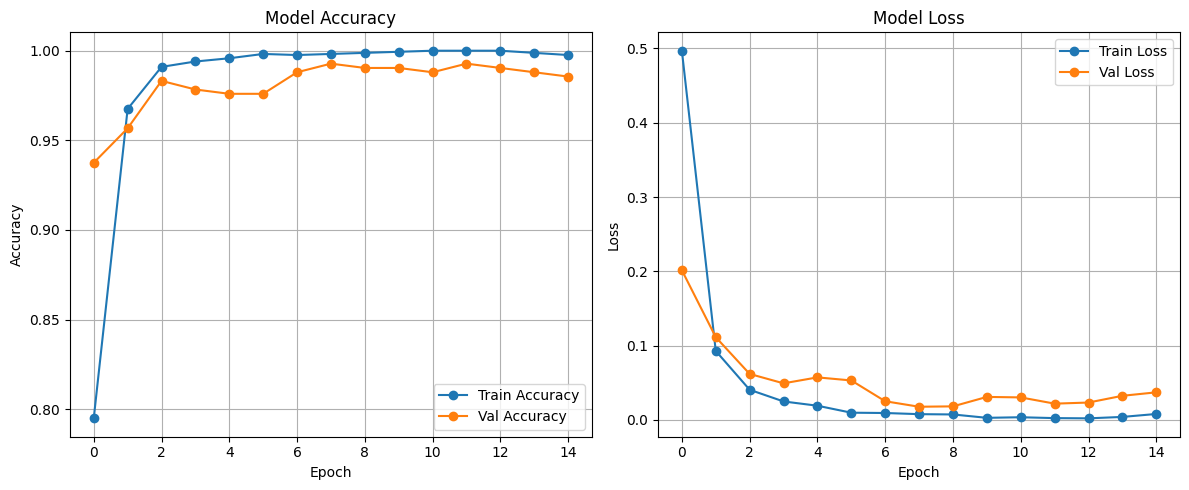

In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# ===========================
# ⚙️ Setup: Data Directories
# ===========================
dataset_path = "./extracted/dataset"  # Replace if needed
categories = ["with_mask", "without_mask", "incorrect_mask"]
label_map = {cat: idx for idx, cat in enumerate(categories)}

train_images = []
train_labels = []

img_size = (128, 128)

# ===========================
# 📥 Load and Label Images
# ===========================
for label_name, label_index in label_map.items():
    dir_path = os.path.join(dataset_path, label_name)
    for fname in os.listdir(dir_path):
        if fname.lower().endswith(('.jpg', '.png', '.jpeg')):
            img = Image.open(os.path.join(dir_path, fname)).convert("RGB")
            img = img.resize(img_size)
            img_array = np.array(img)
            if img_array.shape == (128, 128, 3):
                train_images.append(img_array)
                train_labels.append(label_index)

# ===========================
# ✅ Convert & One-Hot Encode
# ===========================
train_images = np.array(train_images, dtype='float32') / 255.0
train_labels = to_categorical(np.array(train_labels), num_classes=3)

# ===========================
# 📊 Split Dataset
# ===========================
X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42, stratify=train_labels
)

# ===========================
# 🔁 Data Augmentation
# ===========================
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()  # no augmentation

train_generator = train_datagen.flow(X_train, y_train, batch_size=64)
val_generator = val_datagen.flow(X_val, y_val, batch_size=64)

# ===========================
# 🧠 Define MobileNetV2 Model
# ===========================
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# ===========================
# 🚀 Train the Model
# ===========================
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator
)

# ===========================
# 💾 Save the Model
# ===========================
model.save("mobilenet_mask_multiclass.h5")
print("✅ Model saved as mobilenet_mask_multiclass.h5")

# ===========================
# 📈 Plot Accuracy & Loss
# ===========================
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

print(f"🟢 Final Training Accuracy: {train_acc:.4f}")
print(f"🔵 Final Validation Accuracy: {val_acc:.4f}")
print(f"🟢 Final Training Loss: {train_loss:.4f}")
print(f"🔵 Final Validation Loss: {val_loss:.4f}")

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
import numpy as np

# ===========================
# 📦 Load Trained Keras Model
# ===========================
model = tf.keras.models.load_model("mobilenet_mask_multiclass.h5")
print("✅ Loaded Keras model.")

# ===========================
# 🧪 Define Representative Dataset
# ===========================
# Make sure X_train is available and normalized (0-1)
# Pick 100 samples to simulate inference during conversion
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(X_train).batch(1).take(100):
        yield [tf.cast(input_value, tf.float32)]

# ===========================
# 🔁 Convert to Quantized TFLite
# ===========================
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Enable optimizations
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Provide representative dataset for INT8
converter.representative_dataset = representative_data_gen

# Set inference types
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

# 🔄 Convert the model
quant_model = converter.convert()

# ===========================
# 💾 Save TFLite Quantized Model
# ===========================
with open("mobilenet_mask_multiclass_int8.tflite", "wb") as f:
    f.write(quant_model)

print("✅ INT8 quantized TFLite model saved as mobilenet_mask_multiclass_int8.tflite")


✅ Loaded Keras model.
Saved artifact at '/tmp/tmplvzcle0y'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  137771010884240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137771010897104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137771010897488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137771010897296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137771010884048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137771010896912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137771010898832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137771010899600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137771010899024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137771010896720: TensorSpec(shape=(), dtype=tf.resource, name

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


✅ INT8 quantized TFLite model saved as mobilenet_mask_multiclass_int8.tflite


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import time
from PIL import Image

# === Load Haar Cascade for Face Detection ===
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# === Load the quantized TFLite model ===
interpreter = tf.lite.Interpreter(model_path="mobilenet_mask_multiclass_int8.tflite")
interpreter.allocate_tensors()
print("✅ INT8 TFLite model loaded.")

# === Get input/output details ===
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_index = input_details[0]['index']
output_index = output_details[0]['index']
input_scale, input_zero_point = input_details[0]['quantization']
output_scale, output_zero_point = output_details[0]['quantization']

# === Label Mapping ===
class_names = ["With Mask", "Without Mask", "Improper Mask"]

def preprocess_face(face_img):
    """Preprocess cropped face image for TFLite model."""
    face_resized = cv2.resize(face_img, (128, 128))
    face_normalized = face_resized.astype(np.float32) / 255.0
    face_quantized = face_normalized / input_scale + input_zero_point
    face_quantized = face_quantized.astype(np.uint8)
    return np.expand_dims(face_quantized, axis=0)

def predict_face(face_img):
    input_tensor = preprocess_face(face_img)
    interpreter.set_tensor(input_index, input_tensor)
    interpreter.invoke()
    output = interpreter.get_tensor(output_index)[0]
    probabilities = (output.astype(np.float32) - output_zero_point) * output_scale
    predicted_index = np.argmax(probabilities)
    return class_names[predicted_index], np.max(probabilities)

def detect_and_predict(image_path):
    """Detects faces and predicts mask status for each."""
    # Load image
    image = cv2.imread(image_path)
    orig = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    for (x, y, w, h) in faces:
        face = image[y:y+h, x:x+w]
        if face.size == 0:
            continue
        label, confidence = predict_face(face)

        # Draw bounding box and label
        color = (0, 255, 0) if label == "With Mask" else ((0, 255, 255) if label == "Improper Mask" else (0, 0, 255))
        cv2.rectangle(orig, (x, y), (x+w, y+h), color, 2)
        cv2.putText(orig, f"{label} ({confidence*100:.1f}%)", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    # Show the result
    cv2.imshow("Mask Detection", orig)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# ====== USAGE ======
image_path = "/content/download.jpg"  # Change this path to your image
detect_and_predict(image_path)


🕒 Inference Time for face: 0.007719 sec

⏱️ Total Inference Time for image: 0.008394 sec


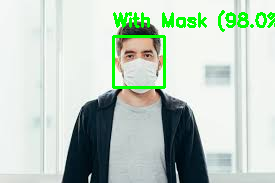

In [ ]:
detect_and_predict("/content/download.jpg")